In [1]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility
from collections import deque
import random
import pickle
import tqdm

## Environment Setup

In [2]:
acrobot_env_name = 'Acrobot-v1'
acrobot_env = gym.make(acrobot_env_name)
# acrobot_env = StepAPICompatibility(acrobot_env)
print("Action space:", acrobot_env.action_space)
print("State space:", acrobot_env.observation_space)
print(acrobot_env.env.spec.id)

Action space: Discrete(3)
State space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Acrobot-v1


In [3]:
assault_env_name = "ALE/Assault-ram-v5"
assault_env = gym.make(assault_env_name)
# assault_env = StepAPICompatibility(assault_env)
print("Action space:", assault_env.action_space)
print("State space:", assault_env.observation_space)
print(assault_env.env.spec.id)

Action space: Discrete(7)
State space: Box(0, 255, (128,), uint8)
ALE/Assault-ram-v5


## Implementation

In [24]:
class ZNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, device="cpu"):
        super(ZNetwork, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
        )
        self.device = device
        self.to(self.device)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
            x = x.to(self.device)
        return self.mlp(x)


# approximates the state-value function using NN
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, device="cpu"):
        super(ValueNetwork, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.device = device
        self.to(self.device)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
            x = x.to(self.device)
        return self.mlp(x)


class BoltzmannPolicy:
    def __init__(self, z_network, temperature=1.0, device="cpu"):
        self.z_network = z_network
        self.temperature = temperature
        self.device = device

    # Boltzmann distribution
    def select_action(self, state):
        # forward ZNetwork
        state_input = torch.as_tensor(state).float().unsqueeze(0).to(self.device)
        z_s = self.z_network(state_input)
        logits = z_s / self.temperature
        probs = torch.nn.functional.softmax(logits, dim=-1)

        # categorical distribution and sample action, exmaple Categorical(probs: tensor([0.1, 0.2, 0.7]))
        m = torch.distributions.Categorical(probs)
        action = m.sample()

        # return action.item(), m.log_prob(action), probs.detach().numpy()
        return action.item(), m.log_prob(action), probs.cpu().detach().numpy()


# REINFORCE is the agent that will train the NN
class REINFORCE:
    def __init__(
        self,
        env,
        lr=0.001,
        gamma=0.99,
        temperature=1.0,
        temp_decay=0.9999,
        decreasing_temp=False,
        max_steps_per_episode=500,
    ):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.z_network = ZNetwork(self.state_dim, self.action_dim)
        # Use Adam instead of SGD
        self.optimizer = optim.Adam(self.z_network.parameters(), lr=lr)
        self.gamma = gamma

        self.max_steps_per_episode = max_steps_per_episode
        self.env_name = env.env.spec.id

        if temperature == "decreasing":
            self.initial_temp = 1
            self.decreasing_temp = True
            self.temp_decay = temp_decay
        else:
            self.initial_temp = temperature
            self.decreasing_temp = decreasing_temp
            self.temp_decay = temp_decay

        self.policy = BoltzmannPolicy(self.z_network, self.initial_temp)

    def train_episode(self, env):
        state, _ = env.reset()
        if self.env_name == "ALE/Assault-ram-v5":
            state = (state / 255) - 0.5
        log_probs = []
        rewards = []
        done = False
        n_steps = 0

        # generate trajectory
        while not done:
            action, log_prob, _ = self.policy.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            n_steps += 1
            if n_steps >= self.max_steps_per_episode:
                done = True
        returns = self._compute_returns(rewards)
        if returns.std() > 0:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # add negative sign because Torch minimizes
        log_probs_tensor = torch.cat(log_probs)
        log_probs_tensor = log_probs_tensor.to(self.device)
        policy_loss = -torch.sum(log_probs_tensor * returns)

        # policy_loss = 0
        # for log_prob, Gt in zip(log_probs, returns):
        #     policy_loss += -log_prob * Gt

        # backprop
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        if self.decreasing_temp:
            self.policy.temperature *= self.temp_decay

        return sum(rewards)

    def _compute_returns(self, rewards):
        returns = []
        Gt = 0
        for Rt in reversed(rewards):
            Gt = Rt + self.gamma * Gt
            returns.insert(0, Gt)
        returns = torch.tensor(returns, device=self.device)
        return returns

    def reset_temperature(self):
        self.policy.temperature = self.initial_temp


class ActorCritic:
    def __init__(
        self,
        env,
        lr_policy=1e-3,
        lr_value=1e-3,
        gamma=0.99,
        temperature=1.0,
        temp_decay=0.9999,
        decreasing_temp=False,
        max_steps_per_episode=500,
    ):
        self.env = env
        self.env_name = env.env.spec.id if env.env and env.env.spec else ""
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        # actor is ZNetwork
        self.z_network = ZNetwork(self.state_dim, self.action_dim)
        self.policy = BoltzmannPolicy(self.z_network, temperature=temperature)
        self.optimizer_policy = optim.Adam(self.z_network.parameters(), lr=lr_policy)

        # critic is ValueNetwork
        self.value_network = ValueNetwork(self.state_dim)
        self.optimizer_value = optim.Adam(self.value_network.parameters(), lr=lr_value)

        self.gamma = gamma
        self.max_steps_per_episode = max_steps_per_episode

        if temperature == "decreasing":
            self.initial_temp = 1
            self.decreasing_temp = True
            self.temp_decay = temp_decay
        else:
            self.initial_temp = temperature
            self.decreasing_temp = decreasing_temp
            self.temp_decay = temp_decay

    def train_episode(self):
        state, _ = self.env.reset()
        if self.env_name == "ALE/Assault-ram-v5":
            state = (state / 255.0) - 0.5
        done = False
        total_reward = 0.0
        steps = 0

        while not done:
            action, log_prob, _ = self.policy.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            # one‐step TD error (advantage)
            # A = R + gamma * V(next_state) − V(state)
            state_tensor = torch.tensor(
                state, dtype=torch.float32, device=self.z_network.device
            )
            value_s = self.value_network(torch.FloatTensor(state_tensor))
            if done:
                value_s_prime = 0.0  # No future reward if episode is done
            else:
                next_state_tensor = torch.tensor(
                    next_state, dtype=torch.float32, device=self.z_network.device
                )
                value_s_prime = self.value_network(next_state_tensor)

            advantage = (reward + self.gamma * value_s_prime - value_s).detach()

            # update critic to reduce TD error to minimize (advantage)^2
            value_loss = advantage.pow(2).mean()

            self.optimizer_value.zero_grad()
            value_loss.backward()
            self.optimizer_value.step()

            # update actor with advantage
            policy_loss = -log_prob * advantage
            self.optimizer_policy.zero_grad()
            policy_loss.backward()
            self.optimizer_policy.step()

            state = next_state
            total_reward += reward
            steps += 1

            if self.decreasing_temp:
                self.policy.temperature *= self.temp_decay

            if steps >= self.max_steps_per_episode:
                break

        return total_reward

    def reset_temperature(self):
        self.policy.temperature = self.initial_temp


def run_trial(env, seed, lr, temperature, algorithm):
    torch.manual_seed(seed)
    np.random.seed(seed)

    num_episodes = 1000

    agent = None
    if algorithm == "REINFORCE":
        agent = REINFORCE(env, lr=lr, temperature=temperature)
    elif algorithm == "Actor-Critic":
        agent = ActorCritic(
            env, lr_policy=lr, lr_value=lr, gamma=0.99, temperature=temperature
        )

    torch.set_grad_enabled(True)

    episode_rewards = []
    for _ in tqdm.tqdm(range(num_episodes)):
        agent.reset_temperature()
        total_reward = agent.train_episode(env)
        episode_rewards.append(total_reward)
    return episode_rewards

In [23]:
episode_rewards = run_trial(acrobot_env, 0, 1e-3, 1.0, "REINFORCE")

# Create a single plot for the specific run
plt.figure(figsize=(10, 6))

# Plot the rewards for each episode
plt.plot(episode_rewards)

# Add labels and title
plt.title("REINFORCE on Acrobot-v1")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True, alpha=0.3)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color="r", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

Using device: cuda


 40%|███▉      | 398/1000 [01:18<01:25,  7.01it/s]

100%|██████████| 500/500 [03:00<00:00,  2.77it/s]


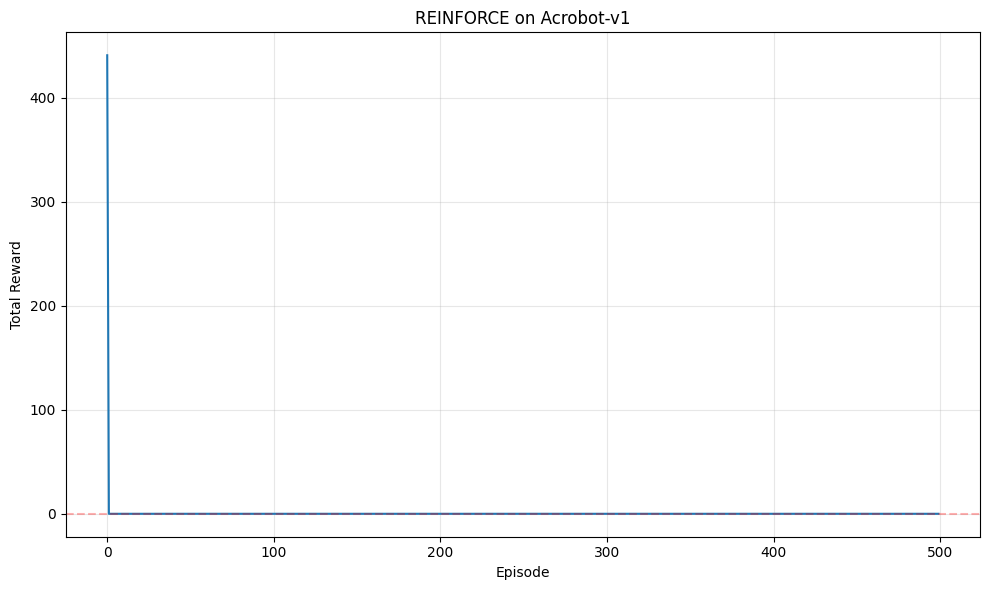

In [13]:
episode_rewards = run_trial(assault_env, 0, 0.01, 1, "REINFORCE")

# Create a single plot for the specific run
plt.figure(figsize=(10, 6))

# Plot the rewards for each episode
plt.plot(episode_rewards)

# Add labels and title
plt.title("REINFORCE on Acrobot-v1")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True, alpha=0.3)

# Add a horizontal line at y=0 for reference
plt.axhline(y=0, color="r", linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()

## Experiment
2 envs, 3 epsilons, 3 step sizes, 2 algos, 2 runs w/wo buffer, 10 seeds (runs)
=720

In [17]:
step_sizes = [0.01]
temperatures = [1, "decreasing"]
seeds = range(10)
envs = [acrobot_env, assault_env]
algorithms = ["REINFORCE", "Actor-Critic"]
algorithms = ["REINFORCE"]

total_trials = (
    len(envs) * len(seeds) * len(step_sizes) * len(temperatures) * len(algorithms)
)

# load pickle file for results, check if file exists
try:
    with open("results_q3.pkl", "rb") as f:
        results = pickle.load(f)
except:
    results = {}

trials_completed = 0
for env in envs:
    env_name = env.env.spec.id
    for lr in step_sizes:
        for temperature in temperatures:
            for algorithm in algorithms:
                for seed in seeds:
                    if not (
                        (
                            env_name,
                            seed,
                            lr,
                            temperature,
                            algorithm,
                        )
                        in results.keys()
                    ):
                        episode_rewards = run_trial(
                            env,
                            seed,
                            lr,
                            temperature,
                            algorithm,
                        )
                        results[
                            (
                                env_name,
                                seed,
                                lr,
                                temperature,
                                algorithm,
                            )
                        ] = episode_rewards
                        with open("results_q3.pkl", "wb") as f:
                            pickle.dump(results, f)
                    trials_completed += 1
                    print(f"Completed {trials_completed}/{total_trials} trials")

100%|██████████| 1000/1000 [01:15<00:00, 13.29it/s]


Completed 1/40 trials


 20%|██        | 205/1000 [01:04<04:50,  2.74it/s]

: 

In [ ]:
for env_name in ["Acrobot-v1", "ALE/Assault-ram-v5"]:
    for use_buffer in [False, True]:
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle(f"{env_name} - {'With' if use_buffer else 'Without'} Replay Buffer")
        
        for i, epsilon in enumerate(epsilons):
            for j, lr in enumerate(step_sizes):
                ax = axes[i, j]
                ax.set_title(f"ε={epsilon}, α={lr}")
                ax.set_xlabel("Episode")
                ax.set_ylabel("Performance")
                
                for algorithm, color in zip(algorithms, ["red", "green"]):
                    all_rewards = []
                    
                    for seed in range(10):
                        key = (env_name, seed, epsilon, lr, algorithm, use_buffer)
                        if key in results:
                            all_rewards.append(results[key])
                        
                    if all_rewards:
                        all_rewards = np.array(all_rewards)
                        mean_rewards = np.mean(all_rewards, axis=0)
                        std_rewards = np.std(all_rewards, axis=0)
                        
                        ax.plot(mean_rewards, label=algorithm, color=color)
                        ax.fill_between(range(len(mean_rewards)), 
                                        mean_rewards - std_rewards, 
                                        mean_rewards + std_rewards, 
                                        color=color, alpha=0.3)
                
                ax.legend()
        
        plt.tight_layout(rect=[0, 0, 1, 0.96])
        plt.savefig(f"{env_name.replace('/', '')}_{'with' if use_buffer else 'without'}_buffer.png")
        plt.show()
        plt.close()